# Import data and libraries

In [0]:
# Main Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction and Over/Undersampling
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import average_precision_score, confusion_matrix

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [0]:
# Import CSV file containing data
data = pd.read_csv('/content/creditcard.csv')

# Exploratory Data Analysis (EDA)

In [0]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Duplicate Detection

In [0]:
# Identify any potential duplicate rows and remove the duplicates
print(data[data.duplicated(keep=False)])
data = data.drop_duplicates()

            Time        V1        V2  ...       V28  Amount  Class
32          26.0 -0.529912  0.873892  ...  0.023307    6.14      0
33          26.0 -0.529912  0.873892  ...  0.023307    6.14      0
34          26.0 -0.535388  0.865268  ...  0.025427    1.77      0
35          26.0 -0.535388  0.865268  ...  0.025427    1.77      0
112         74.0  1.038370  0.127486  ...  0.001192    1.18      0
...          ...       ...       ...  ...       ...     ...    ...
283485  171627.0 -1.457978  1.378203  ...  0.116772   11.93      0
284190  172233.0 -2.667936  3.160505  ... -0.222200   55.66      0
284191  172233.0 -2.667936  3.160505  ... -0.222200   55.66      0
284192  172233.0 -2.691642  3.123168  ... -0.213020   36.74      0
284193  172233.0 -2.691642  3.123168  ... -0.213020   36.74      0

[1854 rows x 31 columns]


### Scale features

In [0]:
# Scale Time and Amount
scaler = StandardScaler()
cols_to_scale = ['Time', 'Amount']

for col in cols_to_scale:
    data[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(data[col])),columns=[col])

### Outlier Detection and Removal

In [0]:
# Outlier Detection and Removal (IQR)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

is_outlier = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
is_outlier = is_outlier.drop('Class', axis=1)
is_outlier = is_outlier.any(axis=1)

data['is_outlier'] = is_outlier

print(data.is_outlier.value_counts())

data = data[data.is_outlier == True]
data = data.drop('is_outlier', axis=1)

True     145734
False    137992
Name: is_outlier, dtype: int64


In [0]:
# Seperate out fraud and legitimate cases for under- and oversampling
fraud = data[data.Class == 1] 
legit = data[data.Class == 0]

print("Number of fraud cases (1):\t\t", len(fraud), "\nNumber of legitimate cases (0):\t", len(legit))

Number of fraud cases (1):		 461 
Number of legitimate cases (0):	 145273


### Undersampling

In [0]:
# Undersample non-fraud cases
legit_under = resample(legit, replace=False, n_samples=461, random_state=1)

# Combine undersampled non-fraud cases with fraud cases
data_under = pd.concat([legit_under, fraud])

data_under.Class.value_counts()

1    461
0    461
Name: Class, dtype: int64

### Oversampling

In [0]:
# Oversample fraud cases
fraud_over = resample(fraud, replace=True, n_samples=145273, random_state=1)

# Combine oversampled fraud cases with non-fraud cases
data_over = pd.concat([fraud_over, legit])

data_over.Class.value_counts()

1    145273
0    145273
Name: Class, dtype: int64

### SMOTE sampling

In [0]:
# SMOTE oversampling fraud cases
X = data.drop(['Class', 'Time', 'Amount'], axis=1)
y = data['Class']

columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']

sm = SMOTE(random_state = 1) 

X, y = sm.fit_sample(X, y.ravel()) 

data_smote = pd.DataFrame(X, columns=columns)
data_smote['Class'] = y

print(data_smote.Class.value_counts())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    145273
0    145273
Name: Class, dtype: int64


### Correlation Matricies

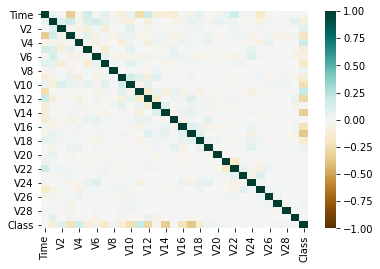

In [0]:
# Correlation matrix with original data
sns.heatmap(data.corr(), vmin=-1, cmap='BrBG');

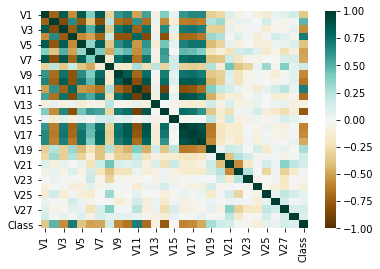

In [0]:
# Correlation matrix with undersampled data
sns.heatmap(data_smote.corr(), vmin=-1, cmap='BrBG');

In [0]:
data_under.corr()['Class']

V1      -0.365844
V2       0.485285
V3      -0.559062
V4       0.704315
V5      -0.384502
V6      -0.498884
V7      -0.477317
V8       0.158637
V9      -0.575185
V10     -0.645050
V11      0.698127
V12     -0.678796
V13     -0.085160
V14     -0.763959
V15      0.000658
V16     -0.591532
V17     -0.567643
V18     -0.468802
V19      0.286803
V20      0.166806
V21      0.136090
V22      0.020436
V23     -0.030308
V24     -0.093291
V25      0.073741
V26      0.043288
V27      0.140318
V28      0.109307
Class    1.000000
Name: Class, dtype: float64

### PCA Dimensionality Reduction for visualization

In [0]:
X = data_under.drop(['Class', 'Amount', 'Time'], axis=1)
y = data_under['Class']

pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(X)

reduced_pca = pd.DataFrame(reduced_pca, columns=["PC1", "PC2"])
reduced_pca['Class'] = y.values
reduced_pca.head()

,PC1,PC2,Class
0,-9.643128,1.073400,0
1,-9.533103,1.145516,0
2,-8.108838,3.531251,0
3,-9.500409,1.437207,0
4,-9.561135,1.196142,0


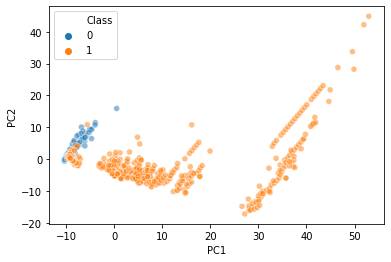

In [0]:
sns.scatterplot(x='PC1', y='PC2', data=reduced_pca, hue='Class', alpha=0.5)

# Classifier Selection

### Prepare Data

In [0]:
# Drop columns identified in EDA
selected_columns = ['V14', 'V4','V12','V11','V10','V16','V3','V9','V17','V2','V7','V18'
,'V6','V1','V5','V19','V20','Class']
data_under = data_under[selected_columns]
data_over = data_over[selected_columns]
data_smote = data_smote[selected_columns]
data_original = data[selected_columns]

# Original Data
X_original = data_original.drop(['Class'], axis=1)
y_original = data_original['Class']
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, test_size=0.20, random_state=1)

# Undersampling
X_under = data_under.drop(['Class'], axis=1)
y_under = data_under['Class']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size=0.20, random_state=1)

# Oversampling
X_over = data_over.drop(['Class'], axis=1)
y_over = data_over['Class']
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over,test_size=0.20, random_state=1)

# Smote
X_smote = data_smote.drop(['Class'], axis=1)
y_smote = data_smote['Class']
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.20, random_state=1 )


### Helper Functions & Variables

In [0]:
# Data used for training
X_train = X_under_train
y_train = y_under_train

# Data used for testing
X_test = X_under_test
y_test = y_under_test

def TuneModel(estimator, param_grid):
  model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=4)
  model.fit(X_train, y_train)
  print("Hyper Parameter Tuning Completed.")
  print("Best estimator:")
  print(model.best_estimator_)
  return model.best_estimator_

def Predict(model):
  prediction = model.predict(X_test)
  report = classification_report(y_test, prediction)
  cf_matrix = confusion_matrix(y_test, prediction)
  ap_score = average_precision_score(y_test, prediction)
  print("Model Performance Metrics\n")
  print(report)
  print('Average precision-recall score: {0:0.3f}'.format(ap_score))
  print("\nConfusion Matrix:")
  sns.heatmap(cf_matrix /np.sum(cf_matrix ), annot=True,
  fmt='.2%', cmap='Blues')


## Random Forrest Classifier

In [0]:
rfc_param_grid = {
  'n_estimators': [50, 100, 200],
  'max_features': ['auto', 'sqrt', 'log2'],
  'max_depth' : [8,9,10],
  'criterion' :['gini', 'entropy']
}
rfc_clf = TuneModel(RandomForestClassifier(random_state=1),
  rfc_param_grid)


Hyper Parameter Tuning Completed.
Best estimator:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


Model Performance Metrics

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        83
           1       0.98      0.91      0.94       102

    accuracy                           0.94       185
   macro avg       0.94      0.94      0.94       185
weighted avg       0.94      0.94      0.94       185

Average precision-recall score: 0.941

Confusion Matrix:


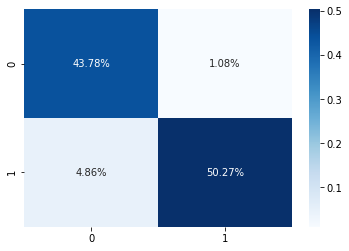

In [0]:
# Prediction based on model
Predict(rfc_clf)

## Logistic Regression

In [0]:
lr_param_grid = {
  'solver': ['liblinear'],
  'penalty' : ['l1', 'l2'],
  'C' : np.logspace(-4, 4, 20),
  'max_iter': [50,100,200]
}
lr_clf = TuneModel(LogisticRegression(random_state=1),
  param_grid = lr_param_grid)

Hyper Parameter Tuning Completed.
Best estimator:
LogisticRegression(C=0.23357214690901212, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Model Performance Metrics

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        83
           1       1.00      0.92      0.96       102

    accuracy                           0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185

Average precision-recall score: 0.965

Confusion Matrix:


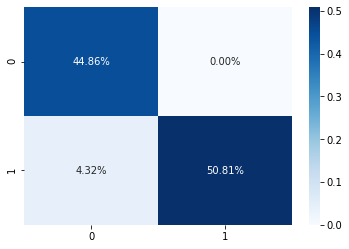

In [0]:
# Prediction based on model
Predict(lr_clf)

## SVC Classifier

In [0]:
svc_param_grid = [
  {
  'kernel': ['rbf'],
  'gamma': [1e-3, 1e-4],
  'C': [1, 10, 100, 1000]
  },
  {
  'kernel': ['linear'],
  'C': [1, 10, 100, 1000]
  }
]
svc_clf = TuneModel(SVC(random_state=1),
  param_grid = svc_param_grid)


Hyper Parameter Tuning Completed.
Best estimator:
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)


Model Performance Metrics

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        83
           1       0.97      0.93      0.95       102

    accuracy                           0.95       185
   macro avg       0.94      0.95      0.95       185
weighted avg       0.95      0.95      0.95       185

Average precision-recall score: 0.941

Confusion Matrix:


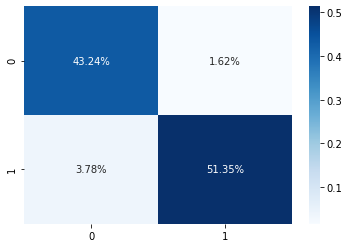

In [0]:
# Prediction based on model
Predict(svc_clf)

## MLP Classifier

In [0]:
mlp_param_grid = {
  'solver': ['lbfgs'],
  'max_iter': [1000,1200,1400,1800,2000],
  'alpha': 10.0 ** -np.arange(1, 10),
  'hidden_layer_sizes':np.arange(10, 15)
 }
mlp_clf = TuneModel(MLPClassifier(random_state=1),
  param_grid = mlp_param_grid)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Hyper Parameter Tuning Completed.
Best estimator:
MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=14, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Performance Metrics

              precision    recall  f1-score   support

           0       0.92      0.95      0.93        83
           1       0.96      0.93      0.95       102

    accuracy                           0.94       185
   macro avg       0.94      0.94      0.94       185
weighted avg       0.94      0.94      0.94       185

Average precision-recall score: 0.932

Confusion Matrix:


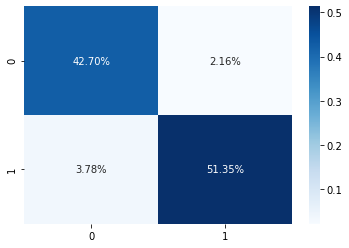

In [0]:
# Prediction based on model
Predict(mlp_clf)